>https://www.gov.uk/government/publications/covid-19-track-coronavirus-cases

### import and wrangling of daily total-cases figures

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import xlrd
import requests
from datetime import datetime

pd.options.display.float_format = '{:.2f}'.format

In [2]:
# download file to my covid data folder

print('Beginning file download with requests')
site = "https://fingertips.phe.org.uk/documents/Historic%20COVID-19%20Dashboard%20Data.xlsx"
req = requests.get(site)

with open('/Users/aidanair/Documents/DATA/ALL_DATASETS/COVID/ukgov_0904.xlsx', 'wb') as f:
    f.write(req.content)
    
# Retrieve HTTP meta-data
print(req.status_code)
print(req.headers['content-type'])
print(req.encoding)

Beginning file download with requests
200
application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
None


In [3]:
# To open Workbook and define the 'sheet' we're on - sheet 3 in this case

path = '/Users/aidanair/Desktop/testing_dl.xlsx'
wb = xlrd.open_workbook(path) 
sheet = wb.sheet_by_index(3) 

In [21]:
# loop through the rows and build a df

big_list = []
row_counter = 7
for x in range(5):
    
    col_counter = 0

    small_list = []
    
    for x in range(33):
        answer = sheet.cell_value(row_counter, col_counter)
        #int(answer)
        small_list.append(answer)
        col_counter = col_counter + 1
    #print(small_list)
    
    big_list.append(small_list)
    row_counter = row_counter + 1
    
df = pd.DataFrame(big_list)

# transform, name cols, drop 2 rows, reset index after dropped rows
df = df.T
df.columns = ['date', 'england', 'scotland', 'wales', 'nireland']
df = df[2:]
df = df.reset_index(drop=True)

df.head()

,date,england,scotland,wales,nireland
0,43899.00,280.00,,,
1,43900.00,324.00,27.00,6.00,16.00
2,43901.00,387.00,36.00,15.00,18.00
3,43902.00,491.00,60.00,25.00,19.00
4,43903.00,645.00,85.00,38.00,29.00


In [22]:
# force the country columns to int

df.england = df.england.astype('Int64')
df.england = df.england.astype('Int64')
df.england = df.england.astype('Int64')
df.england = df.england.astype('Int64')

In [6]:
# define 2 functions, the second of which calls on the first

def conv_excel(problem):
    """takes a number and converts it from a excel time nb to a pandas date. WORKS""" 
    
    python_date = datetime(*xlrd.xldate_as_tuple(problem, 0))
    return str(python_date)[0:10]

def time_conv (col):
    """takes a col number and runs through it calling the conversion function for each row"""
    date_list = []

    row = 0
    for x in range(len(df)):
        problem = df.iat[row,col]  
        answer = conv_excel(problem)
        date_list.append(answer)
        row = row + 1
        
    df['date_ok'] = date_list

    return 'done'


In [23]:
# pass column 0 into the function and run it to convert the excel times to pandas times

time_conv(0)

'done'

In [24]:
# Put NaN in the first row so the population calculations will work

col = (2)
for x in range (3):
    df.iat[0, col] = np.nan
    col = col + 1

In [8]:
# define the population of each nation from ONS figures

eng_pop = 55_977_178
wales_pop = 3_138_631
scot_pop = 5_438_100
nire_pop = 1_881_641

# SOURCE https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/articles/overviewoftheukpopulation/august2019

In [25]:
# calculate cases per million people for each of the nations and place in new column

df['per_M_eng'] = (df.england / eng_pop) * 1_000_000
df['per_M_scot'] = (df.scotland / scot_pop) * 1_000_000
df['per_M_wales'] = (df.wales / wales_pop) * 1_000_000
df['per_M_nire'] = (df.nireland / nire_pop) * 1_000_000

In [26]:
df[:3]

,date,england,scotland,wales,nireland,date_ok,per_M_eng,per_M_scot,per_M_wales,per_M_nire
0,43899.00,280,NaN,NaN,NaN,2020-03-09,5.00,NaN,NaN,NaN
1,43900.00,324,27.00,6.00,16.00,2020-03-10,5.79,4.96,1.91,8.50
2,43901.00,387,36.00,15.00,18.00,2020-03-11,6.91,6.62,4.78,9.57


### analysis. daily total-cases figures are worst in Wales, when adjusted for population

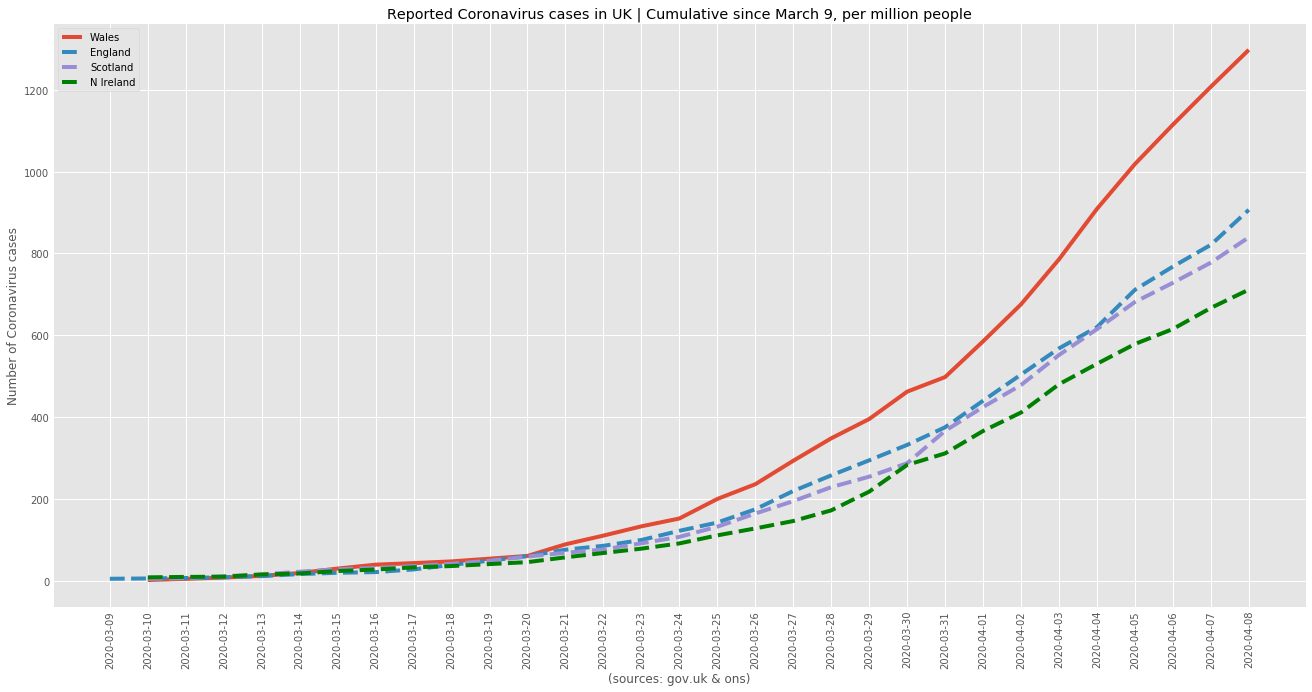

In [32]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (20, 10))

plt.plot(df.date_ok, df.per_M_wales, label='Wales')
plt.plot(df.date_ok, df.per_M_eng, linestyle = "--", label='England')
plt.plot(df.date_ok, df.per_M_scot, linestyle = "--", label='Scotland')
plt.plot(df.date_ok, df.per_M_nire, linestyle = "--", label='N Ireland', color = 'green')

plt.legend(loc='best')

ax.set_title('Reported Coronavirus cases in UK | Cumulative since March 9, per million people')
ax.set_xlabel('(sources: gov.uk & ons)')
ax.set_ylabel('Number of Coronavirus cases')

plt.xticks(rotation = 'vertical')
plt.show()

### uk latest total deaths. import and wrangling

In [37]:

file = 'ukgov_daily_indicators_0904.csv'
path = f"/Users/aidanair/Documents/DATA/ALL_DATASETS/COVID/{file}"
dfd = pd.read_csv(path, encoding = 'utf-8')


(1, 13)

In [39]:
cols = 'date total_uk_cases new_uk_cases total_uk_deaths new_uk_deaths england_cases england_deaths scotland_cases scotland_deaths wales_cases wales_deaths nire_cases nire_deaths'.split()
dfd.columns = cols

In [42]:
# fix England deaths data types

dfd.england_deaths = dfd.england_deaths.str.replace(",", "")
dfd.england_deaths = dfd.england_deaths.astype(int)

#df.england = df.england.astype('Int64')

In [74]:
dfd

,date,total_uk_cases,new_uk_cases,total_uk_deaths_total,new_uk_deaths,england_cases,england_deaths,scotland_cases,scotland_deaths,wales_cases,wales_deaths,nire_cases,nire_deaths,dead_per_M_eng,dead_per_M_scot,dead_per_M_wales,dead_per_M_nire
0,09/04/2020,"65,077","4,344","7,978",881,"54,554",7248,"4,957",366,"4,089",286,"1,477",78,129.48,67.30,91.12,41.45


In [44]:
# get 'deaths per million people' columns

dfd['dead_per_M_eng'] = (dfd.england_deaths / eng_pop) * 1_000_000
dfd['dead_per_M_scot'] = (dfd.scotland_deaths / scot_pop) * 1_000_000
dfd['dead_per_M_wales'] = (dfd.wales_deaths / wales_pop) * 1_000_000
dfd['dead_per_M_nire'] = (dfd.nire_deaths / nire_pop) * 1_000_000

In [46]:
# new df doing just the per_million columns

dfd_pop_dead = dfd.iloc[:,13:17]
dfd_pop_dead

,dead_per_M_eng,dead_per_M_scot,dead_per_M_wales,dead_per_M_nire
0,129.48,67.30,91.12,41.45


In [66]:
list(dfd_pop_dead.iloc[0])

[129.48133969883227, 67.30291829867049, 91.12253081040747, 41.453178369306364]

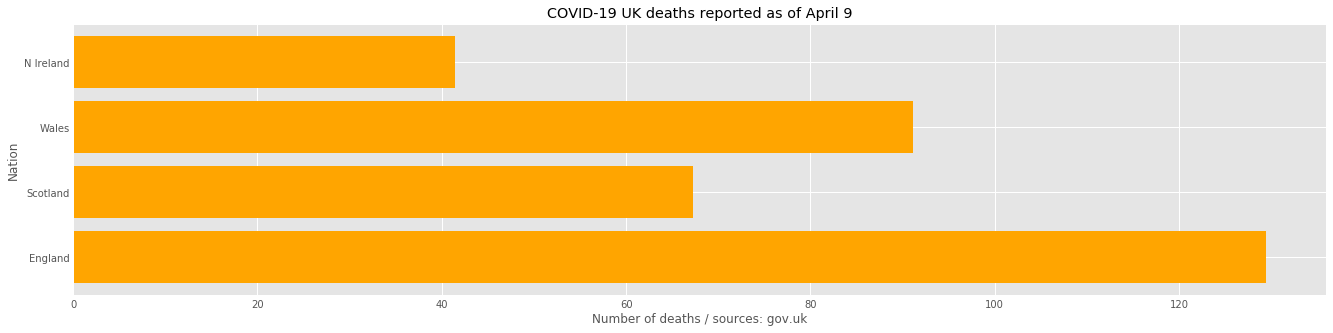

In [82]:
plt.style.use('ggplot')
plt.subplots(figsize = (20, 5))

x = list(dfd_pop_dead.iloc[0])
y = ['England', 'Scotland', 'Wales', 'N Ireland']

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, x, color='orange')
plt.yticks(x_pos, y)

plt.ylabel("Nation")
plt.xlabel("Number of deaths / sources: gov.uk")
plt.title("COVID-19 UK deaths reported as of April 9")

plt.show()